## ICESat-2 SlideRule Download

This code is adapted from Sliderule Python example code. It is designed to calculate ATL06 elevations from ALT03 points and save those elevations as a CSV. 

Activate IS2alpinesnow enviroment to run

Last updated by Karina Zikan September 2022

In [1]:
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5

## SlideRule Configuration

In [2]:
# Configure ICESat-2 API
icesat2.init("slideruleearth.io", verbose=False)

## Specify Region of Interest

#### 1. Make geojson from shapefile - if you have a geojson of the region skip to 2.

In [ ]:
# Specify region of interest shapefile
shp = "Sites/RCEW/ROIs/RCEW-outline_WGS84.shp"
shapefile = gpd.read_file(shp)
# shapefile.to_file('DryCreek/boundDCEW/boundDCEW_WGS84.geojson', driver='GeoJSON')
shapefile.crs is None

##### - Check shapefile crs

In [ ]:
## if shapefile.crs is None is false check the crs
shapefile.crs

##### - Make Geojson

In [ ]:
shapefile.to_file('Sites/RCEW/ROIs/RCEW-outline_WGS84.geojson', driver='GeoJSON')

In [ ]:
## if shapefile.crs is None is true run this section
#crs = 'epsg:8826' # set the starting datum using the epsg code
#icesat_crs = 4979 # epsg code for WGS84
#shapefile = shapefile.set_crs(crs)
#shapefile = shapefile.to_crs(icesat_crs) # transform to WGS84 
#shapefile.to_file('/Mores/MCSboundary/MoresBound_WGS84.geojson', driver='GeoJSON')

In [ ]:
## if shapefile.crs is not WGS84 run this section
#icesat_crs = 4979 # epsg code for WGS84
#shapefile = shapefile.to_crs(icesat_crs) # transform to WGS84 
#shapefile.to_file('/Mores/MCSboundary/MoresBound_WGS84.geojson', driver='GeoJSON')

#### 2. Read in geojson for Region of Interest

In [3]:
# Specify region of interest from geojson
poly_fn = 'Sites/RCEW/ROIs/RCEW-outline_WGS84.geojson'
region = sliderule.toregion(poly_fn)["poly"] # symplify 
region

[{'lon': -116.799, 'lat': 43.06089},
 {'lon': -116.7954, 'lat': 43.06089},
 {'lon': -116.7481, 'lat': 43.06268},
 {'lon': -116.747, 'lat': 43.06295},
 {'lon': -116.7411, 'lat': 43.06456},
 {'lon': -116.7409, 'lat': 43.06469},
 {'lon': -116.7392, 'lat': 43.06591},
 {'lon': -116.7379, 'lat': 43.06712},
 {'lon': -116.7179, 'lat': 43.09706},
 {'lon': -116.7008, 'lat': 43.12889},
 {'lon': -116.6963, 'lat': 43.13834},
 {'lon': -116.696, 'lat': 43.13915},
 {'lon': -116.6922, 'lat': 43.15454},
 {'lon': -116.6881, 'lat': 43.22341},
 {'lon': -116.6881, 'lat': 43.22476},
 {'lon': -116.6947, 'lat': 43.24693},
 {'lon': -116.6954, 'lat': 43.24828},
 {'lon': -116.6958, 'lat': 43.24883},
 {'lon': -116.702, 'lat': 43.2564},
 {'lon': -116.7022, 'lat': 43.25654},
 {'lon': -116.7579, 'lat': 43.2872},
 {'lon': -116.7605, 'lat': 43.28828},
 {'lon': -116.7612, 'lat': 43.28856},
 {'lon': -116.8199, 'lat': 43.31163},
 {'lon': -116.8251, 'lat': 43.31298},
 {'lon': -116.8266, 'lat': 43.31218},
 {'lon': -116.8303

In [4]:
# Prepare coordinate lists for plotting the region of interest polygon
region_lon = [e["lon"] for e in region]
region_lat = [e["lat"] for e in region]

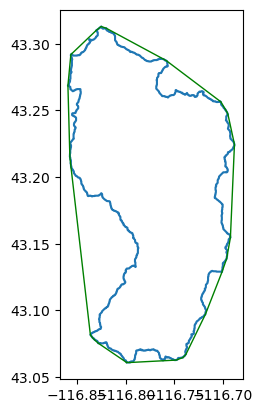

In [5]:
# Read geojson with geopandas
pregion = gpd.read_file(poly_fn)
map = pregion.plot(); # plot origonal boundery 
map.plot(region_lon, region_lat, linewidth=1, color='g'); # plot symplified region boundery for a sanity check

#### 3. Save simplified polygon

In [6]:
polygon_geom = Polygon(zip(region_lon, region_lat))
crs = 'epsg:4979'
polygon = gpd.GeoDataFrame(index=[0], geometry=[polygon_geom])       

polygon

,geometry
0,"POLYGON ((-116.79900 43.06089, -116.79540 43.0..."


### Save to file if you haven't already

In [ ]:
polygon.to_file('Sites/RCEW/ROIs/RCEW-outline_WGS84_simple.geojson', driver='GeoJSON')

# Sliderule Product processing

Follow the processing section for the desired product

### ATL03 processing

#### ATL03 Parameters

In [7]:
parms = {
    "poly": region,
    "srt": 0,
    "atl08_class": "atl08_ground",
    "cnf": icesat2.CNF_BACKGROUND, 
    "ats": 20.0,
    "cnt": 10, 
    "len": 40.0,
    "res": 20.0,
    "maxi": 6
}
cvs_name = "Sites/RCEW/IS2_Data/RCEW-ICESat2-ATL03.csv" #set name of the output

#### Calculate Elevations

In [8]:
# Latch Start Time
perf_start = time.perf_counter()

# Request ATL06 Data
data = icesat2.atl03sp(parms)

# Latch Stop Time
perf_stop = time.perf_counter()

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
#print("Reference Ground Tracks: {}".format(atl06_sr["rgt"].unique()))
#print("Cycles: {}".format(atl06_sr["cycle"].unique()))
print("Received {} elevations".format(data.shape[0]))

Completed in 178.405 seconds of wall-clock time
Received 4929329 elevations


## Data Check

In [9]:
#Set utmzone code - utm zone 11:32611
utm_code = 'epsg:32611' 

data['Longitude'] = data['geometry'].x
data['Latitude'] = data['geometry'].y
eastnorths = data['geometry'].to_crs(utm_code)
data['Easting'] = eastnorths.x
data['Northing'] = eastnorths.y
data

,solar_elevation,background_rate,segment_dist,track,segment_id,cycle,sc_orient,rgt,distance,atl08_class,...,yapc_score,height,quality_ph,pair,geometry,spot,Longitude,Latitude,Easting,Northing
time,,,,,,,,,,,,,,,,,,,,,
2018-11-26 21:09:05.599375104,22.217052,1.400436e+06,4.804206e+06,1,239567,1,1,905,-19.499467,1,...,0,1569.248047,0,0,POINT (-116.69187 43.16437),6,-116.691871,43.164365,525048.015097,4.779114e+06
2018-11-26 21:09:05.602074880,22.217052,1.400436e+06,4.804206e+06,1,239567,1,1,905,-0.294193,1,...,0,1568.380493,0,0,POINT (-116.69189 43.16454),6,-116.691894,43.164537,525046.121713,4.779133e+06
2018-11-26 21:09:05.605675008,22.216734,1.420321e+06,4.804246e+06,1,239569,1,1,905,-14.762325,1,...,0,1567.851196,0,0,POINT (-116.69192 43.16477),6,-116.691924,43.164767,525043.583608,4.779158e+06
2018-11-26 21:09:05.605675008,22.216892,1.433332e+06,4.804226e+06,1,239568,1,1,905,5.279596,1,...,0,1567.851196,0,0,POINT (-116.69192 43.16477),6,-116.691924,43.164767,525043.583608,4.779158e+06
2018-11-26 21:09:05.605774848,22.216734,1.420321e+06,4.804246e+06,1,239569,1,1,905,-14.050492,1,...,0,1568.003784,0,0,POINT (-116.69192 43.16477),6,-116.691925,43.164773,525043.513415,4.779159e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-20 04:06:51.403033088,-14.421552,1.375344e+04,4.821422e+06,1,240426,16,1,905,16.638936,1,...,0,1795.748047,0,1,POINT (-116.82894 43.31070),5,-116.828944,43.310705,513872.009351,4.795333e+06
2022-08-20 04:06:51.403132928,-14.421552,1.375344e+04,4.821422e+06,1,240426,16,1,905,17.347915,1,...,0,1795.628174,0,1,POINT (-116.82895 43.31071),5,-116.828945,43.310711,513871.930533,4.795334e+06
2022-08-20 04:06:51.403233024,-14.421552,1.375344e+04,4.821422e+06,1,240426,16,1,905,18.061899,1,...,0,1795.553833,0,1,POINT (-116.82895 43.31072),5,-116.828946,43.310718,513871.860290,4.795335e+06


## Write CSV - ATL03

#### filter to summer months

In [10]:
import datetime 

In [11]:
data['Date'] = pd.to_datetime(data.index)
data = data[(data['Date'].dt.month >= 5) & (data['Date'].dt.month <= 9)]
data[1:6]

,solar_elevation,background_rate,segment_dist,track,segment_id,cycle,sc_orient,rgt,distance,atl08_class,...,height,quality_ph,pair,geometry,spot,Longitude,Latitude,Easting,Northing,Date
time,,,,,,,,,,,,,,,,,,,,,
2019-05-27 12:28:42.744737536,1.957178,187616.531051,4.798193e+06,1,239267,3,0,905,-9.206739,1,...,1898.887573,0,0,POINT (-116.71204 43.10867),1,-116.712038,43.108667,523429.877709,4.772922e+06,2019-05-27 12:28:42.744737536
2019-05-27 12:28:42.745137664,1.957178,187616.531051,4.798193e+06,1,239267,3,0,905,-6.335362,1,...,1898.069214,0,0,POINT (-116.71204 43.10869),1,-116.712042,43.108693,523429.578021,4.772925e+06,2019-05-27 12:28:42.745137664
2019-05-27 12:28:42.745337600,1.957178,187616.531051,4.798193e+06,1,239267,3,0,905,-4.903733,1,...,1898.576050,0,0,POINT (-116.71204 43.10871),1,-116.712044,43.108706,523429.435821,4.772927e+06,2019-05-27 12:28:42.745337600
2019-05-27 12:28:42.745437696,1.957178,187616.531051,4.798193e+06,1,239267,3,0,905,-4.182673,1,...,1897.747925,0,0,POINT (-116.71204 43.10871),1,-116.712045,43.108712,523429.355678,4.772927e+06,2019-05-27 12:28:42.745437696
2019-05-27 12:28:42.745737728,1.957178,187616.531051,4.798193e+06,1,239267,3,0,905,-2.026851,1,...,1896.804077,0,0,POINT (-116.71205 43.10873),1,-116.712047,43.108731,523429.128121,4.772930e+06,2019-05-27 12:28:42.745737728


In [19]:
data_xyz = pd.DataFrame()

data_xyz['E'] = data['Easting']
data_xyz['N'] = data['Northing']
data_xyz['z'] = data['height']
data_xyz['rgt'] = data['rgt']
data_xyz['time'] = data['time']

data_xyz = data_xyz.set_index('time')
data_xyz

,X,Y,Z
rgt,,,
905,523430.475310,4.772917e+06,1900.331543
905,523429.877709,4.772922e+06,1898.887573
905,523429.578021,4.772925e+06,1898.069214
905,523429.435821,4.772927e+06,1898.576050
905,523429.355678,4.772927e+06,1897.747925
...,...,...,...
905,513872.009351,4.795333e+06,1795.748047
905,513871.930533,4.795334e+06,1795.628174
905,513871.860290,4.795335e+06,1795.553833


#### Write CSV

In [ ]:
data_xyz.to_csv(cvs_name)

#### Write LAS

In [13]:
import lasio

In [20]:
las = lasio.LASFile()
las.set_data(data_xyz)

In [22]:
las.write('Sites/RCEW/IS2_Data/RCEW-ICESat2-ATL03.las', version=1.2)